In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
from adan_pytorch import Adan
import numpy as np
# from utils import preparte_data_loader
# from utils import set_parameter_requires_grad
from utils import DEVICE, LOSS_CRITERIA
import time
from utils import DEVICE, AudioDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformers import HubertConfig, HubertForSequenceClassification
from madgrad import MADGRAD
import schedulefree
import pickle
torch.cuda.empty_cache()

/home/mlspeech/royweber/anaconda3/envs/roy_lang/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed = 20
np.random.seed(seed)
torch.manual_seed(seed)

### our training cycle - we want to train hubert from scratch to visualize the comparison between the different optimizers:

In [23]:



def train_model(model, dataloaders, optimizer, num_epochs=25, device=DEVICE, loss_criteria = LOSS_CRITERIA):
    since = time.time()

    val_acc_history = []
    training_acc = []
    training_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                if type(optimizer) == schedulefree.adamw_schedulefree.AdamWScheduleFree:
                    optimizer.train()
            else:
                model.eval()   # Set model to evaluate mode
                if type(optimizer) == schedulefree.adamw_schedulefree.AdamWScheduleFree:
                    optimizer.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # outputs = model(inputs)
                    logits_h = model(inputs).logits.type(torch.cuda.FloatTensor)
                    labels = labels.type(torch.cuda.FloatTensor)
                    loss = loss_criteria(logits_h.view(-1), labels.view(-1))
                    # loss = loss_criteria(outputs, labels)

                    _, preds = torch.max(logits_h, 1)
                    _, real_labels = torch.max(labels, 1)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # zero the parameter gradients
                        optimizer.zero_grad()
                        loss.backward()
                        if type(optimizer) == MADGRAD:
                            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                        
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                
                running_corrects += torch.sum(preds == real_labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss.append(epoch_loss)
            if phase == 'train':
                training_acc.append(epoch_acc)
                training_loss.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, training_acc, val_acc_history,training_loss,val_loss

### loading audio data with batch 64:

we took a sample of the whole dataset in order to be able to train with the current resources - only the first half of the audio

we examine the data in the data preperation to section to check that we dont ruin the process by shortening the samples

we took the ecs - 10 data set but the notebook is also fine for the 50 ecs - all you need to do is to change the flag ONLY_10_LABELS in the util section and train again

In [24]:
train_dataset = AudioDataset(kind='train')
val_dataset = AudioDataset(kind='test')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

dataloaders = {
    'train':train_loader,
    'val':val_loader
}


### Hubert
we took Hubert which has big architucture and lower its dimension and parrameters - instead of couple of conv layers we saved three 

also we used less attention heads and hidden sizes

this affect the generalize capabilities of the model but improve the training dramatically

### optuna

we ran for 100 trails (or 10 minutes) on validation set for each model to gather the best configuration for each optimizer 

In [3]:

config = HubertConfig(
    hidden_size=128,
    num_hidden_layers=2,
    num_attention_heads=4,
    intermediate_size=256,
    num_labels=50,
    conv_dim=(512, 512, 512),
    conv_stride=(5, 2, 2),
    conv_kernel=(10, 3, 3)
    )
hubert_model = HubertForSequenceClassification(config) 

param_size = 0
for param in hubert_model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in hubert_model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
size_all_mb = (param_size + buffer_size) / 1024 ** 2
print(f"model size: {size_all_mb:.2f} MB") 

num_trainable_params = sum([p.numel() for p in hubert_model.parameters() if p.requires_grad])
print(f"model trainable params: {num_trainable_params}")


model size: 7.97 MB
model trainable params: 2088242


In [26]:
# 'Adam': optim.Adam(hubert_model.parameters(), lr=0.0013),
#     'SGD': torch.optim.SGD(hubert_model.parameters(), lr=0.00071, momentum=0.756, nesterov=True),
#     'Adan': Adan(hubert_model.parameters(),lr = 0.0012, betas = (0.04, 0.091, 0.072), weight_decay = 0.02),
#     'Madgrad': MADGRAD(params=hubert_model.parameters(), lr=0.0019, momentum=0.934, weight_decay=0, eps= 1e-06, decouple_decay=False) 

#study - 11 - 12
# 'Adam': optim.Adam(hubert_model.parameters(), lr=0.00055), #7 min
#     # 'SGD': torch.optim.SGD(hubert_model.parameters(), lr=0.0022, momentum=0.307, nesterov=True), #11 min
#     'Adan': Adan(hubert_model.parameters(),lr = 0.0024, betas = (0.082, 0.0717, 0.0783), weight_decay = 0.02), #9 min
#     'Madgrad': MADGRAD(params=hubert_model.parameters(), lr=0.00035, momentum=0.912, weight_decay=0, eps= 1e-06, decouple_decay=False)  #9 min

#longer optuna - 13
# 'Adam': optim.Adam(hubert_model.parameters(), lr=0.00098), #7 min
#     'SGD': torch.optim.SGD(hubert_model.parameters(), lr=0.0011, momentum=0.552, nesterov=True), #11 min
#     'Adan': Adan(hubert_model.parameters(),lr = 0.005, betas = (0.0444, 0.0433, 0.099), weight_decay = 0.02), #9 min
#     'Madgrad': MADGRAD(params=hubert_model.parameters(), lr=1e-4, momentum=0.9087, weight_decay=0, eps= 1e-06, decouple_decay=False),  #9 min


In [50]:

results_metric = {
    'Adam':{
        
    },
    'SGD':{
        
    },
    'Adan':{
        
    },
    'Madgrad':{
        
    },
    'Schedulefree':{
        
    }
}

config = HubertConfig(
    hidden_size=128,
    num_hidden_layers=2,
    num_attention_heads=4,
    intermediate_size=256,
    num_labels=10,
    conv_dim=(512, 512, 512),
    conv_stride=(5, 2, 2),
    conv_kernel=(10, 3, 3)
    )

optimizers = ['Adan','Adam','Madgrad','SGD', 'Schedulefree']

for optimizer_name in optimizers:
    hubert_model = HubertForSequenceClassification(config)   
    final_optimizer_configurations = {
    'Adam': optim.Adam(hubert_model.parameters(), lr=0.00098), #7 min
    'SGD': torch.optim.SGD(hubert_model.parameters(), lr=0.0011, momentum=0.552, nesterov=True), #11 min
    'Adan': Adan(hubert_model.parameters(),lr = 0.005, betas = (0.0444, 0.0433, 0.099), weight_decay = 0.02), #9 min
    'Madgrad': MADGRAD(params=hubert_model.parameters(), lr=1e-4, momentum=0.9087, weight_decay=0, eps= 1e-06, decouple_decay=False),  #9 min
    'Schedulefree': schedulefree.AdamWScheduleFree(hubert_model.parameters(), lr=1e-3)
    }
    hubert_model = hubert_model.to(DEVICE) 
    
    model, training_acc, val_acc_history,training_loss,val_loss = train_model(hubert_model, dataloaders,
                                final_optimizer_configurations[optimizer_name], num_epochs=100, device=DEVICE, loss_criteria = LOSS_CRITERIA)
    results_metric[optimizer_name]['training_acc'] = training_acc
    results_metric[optimizer_name]['val_acc_history'] = val_acc_history
    results_metric[optimizer_name]['training_loss'] = training_loss
    results_metric[optimizer_name]['val_loss'] = val_loss
    results_metric[optimizer_name]['model'] = model

    
    with open('study_20240812/results_20240812_free.pickle', 'wb') as handle:
        pickle.dump(results_metric, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 0/499
----------


train Loss: 388.0268 Acc: 0.1625
val Loss: 336.2967 Acc: 0.2125

Epoch 1/499
----------
train Loss: 372.2788 Acc: 0.3458
val Loss: 323.0961 Acc: 0.3000

Epoch 2/499
----------
train Loss: 356.3921 Acc: 0.3917
val Loss: 308.3126 Acc: 0.4750

Epoch 3/499
----------
train Loss: 341.6880 Acc: 0.4583
val Loss: 301.0465 Acc: 0.4625

Epoch 4/499
----------
train Loss: 337.2841 Acc: 0.4583
val Loss: 299.8855 Acc: 0.4750

Epoch 5/499
----------
train Loss: 328.4900 Acc: 0.5417
val Loss: 297.1454 Acc: 0.4625

Epoch 6/499
----------
train Loss: 323.1086 Acc: 0.5917
val Loss: 293.8246 Acc: 0.4875

Epoch 7/499
----------
train Loss: 320.5033 Acc: 0.6000
val Loss: 294.3018 Acc: 0.5000

Epoch 8/499
----------
train Loss: 315.1180 Acc: 0.6167
val Loss: 293.9745 Acc: 0.5500

Epoch 9/499
----------
train Loss: 311.5379 Acc: 0.6458
val Loss: 292.0964 Acc: 0.5000

Epoch 10/499
----------
train Loss: 309.2670 Acc: 0.6625
val Loss: 292.2859 Acc: 0.5625

Epoch 11/499
----------
train Loss: 304.4125 Acc: 0.68

In [25]:
def plot_loss_curve(results_metric, val=True, train=True):
    plt.figure(figsize=(10, 5))
    for opt in results_metric:
        try:
            d = results_metric[opt]
            
            if train:
            
                training_loss = [i for i in d['training_loss']]#.cpu().numpy().tolist()
                plt.plot(training_loss, label=f'Train Loss {opt}')
            if val:
                val_acc_history = [i for i in d['val_loss']]#.cpu().numpy().tolist()
                plt.plot(val_acc_history, label=f'Validation Loss {opt}')
            
        except:
            continue
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [26]:
def plot_accuracy_curve(results_metric, val=True, train=True):
    plt.figure(figsize=(10, 5))
    for opt in results_metric:
        try:
            d = results_metric[opt]
            if train:
                training_loss = [i.cpu().numpy().tolist() for i in d['training_acc']]#
                plt.plot(training_loss, label=f'Train accuracy {opt}')
            if val:
                val_acc_history = [i.cpu().numpy().tolist() for i in d['val_acc_history']]#.cpu().numpy().tolist()
                plt.plot(val_acc_history, label=f'Validation accuracy {opt}')
        # plot_results(training_loss,val_acc_history)
        except:
            continue
        
        
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


### Trail one:
    'Adam': optim.Adam(hubert_model.parameters(), lr=0.00098),

    'SGD': torch.optim.SGD(hubert_model.parameters(), lr=0.0011, momentum=0.552, nesterov=True),

    'Adan': Adan(hubert_model.parameters(),lr = 0.005, betas = (0.0444, 0.0433, 0.099), weight_decay = 0.02),

    'Madgrad': MADGRAD(params=hubert_model.parameters(), lr=1e-4, momentum=0.9087, weight_decay=0, eps= 1e-06, decouple_decay=False),

    'Schedulefree': schedulefree.AdamWScheduleFree(hubert_model.parameters(), lr=1e-3)

In [36]:
# with open('study_20240809/results_20240809.pickle', 'rb') as handle:
#     final_results = pickle.load(handle)
    
# for opt in ['Adam', 'SGD', 'Adan', 'Madgrad']:
#     final_results[opt].pop('model')
#     print(final_results[opt].keys())
# with open('trail_one/madgrad_fail.pickle', 'wb') as handle:
#     pickle.dump(final_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
# final_results['Adam']

# a:dict = {'a':1}
# a.pop('a')

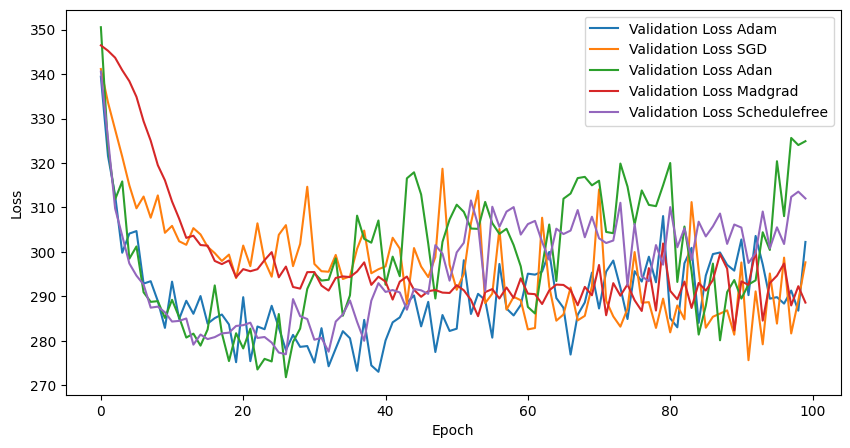

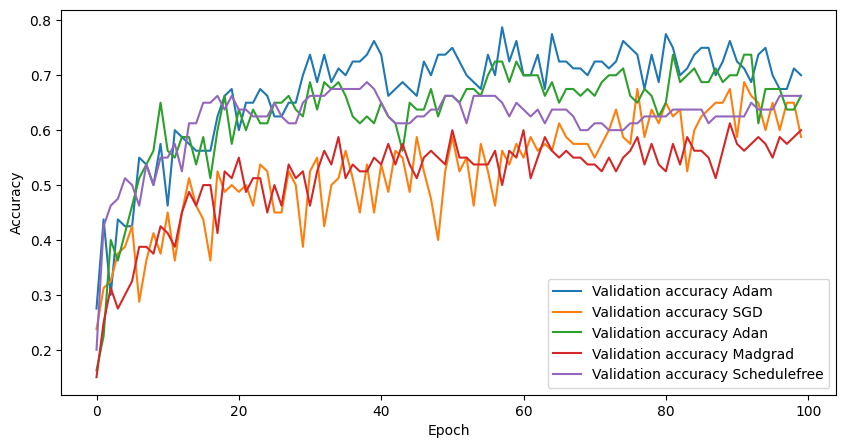

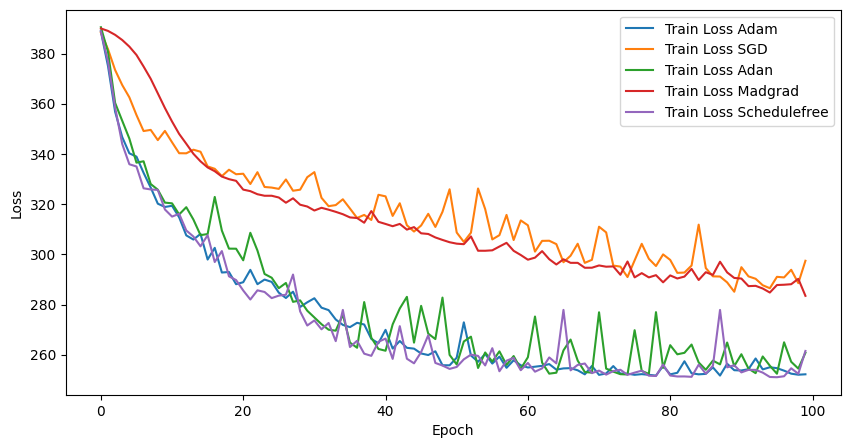

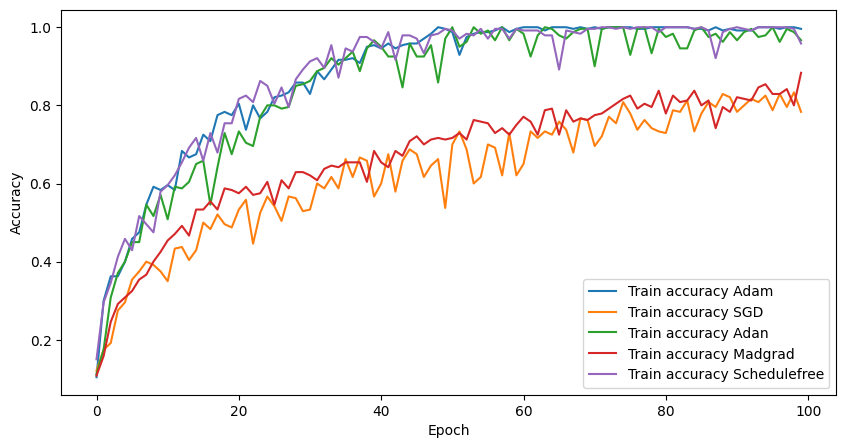

In [32]:

import pickle
with open('trail_one/results.pickle', 'rb') as handle:
    final_results = pickle.load(handle)
plot_loss_curve(final_results, val=True, train=False)
plot_accuracy_curve(final_results, val=True, train=False)
plot_loss_curve(final_results, train=True, val=False)
plot_accuracy_curve(final_results, train=True, val=False)

### trail two 
'Adam': optim.Adam(hubert_model.parameters(), lr=0.00055), 

'SGD': torch.optim.SGD(hubert_model.parameters(), lr=0.0022, momentum=0.307, nesterov=True), 

'Adan': Adan(hubert_model.parameters(),lr = 0.0024, betas = (0.082, 0.0717, 0.0783), weight_decay = 0.02), 

'Madgrad': MADGRAD(params=hubert_model.parameters(), lr=0.00035, momentum=0.912, weight_decay=0, eps= 1e-06, decouple_decay=False) 

'Schedulefree': schedulefree.AdamWScheduleFree(hubert_model.parameters(), lr=1e-3)

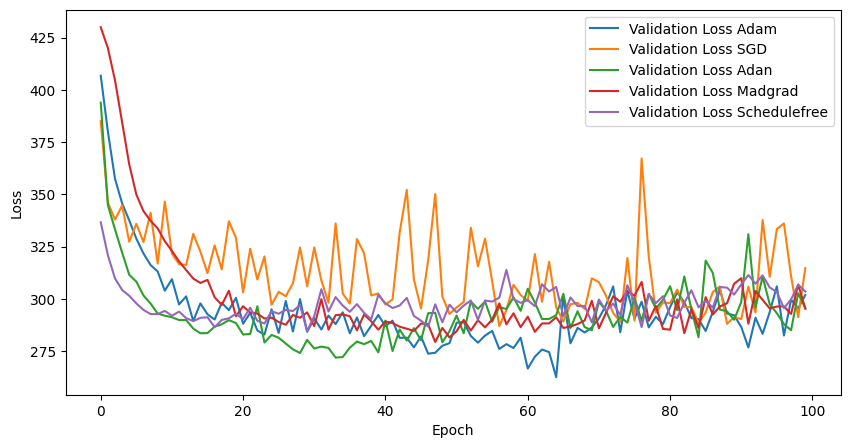

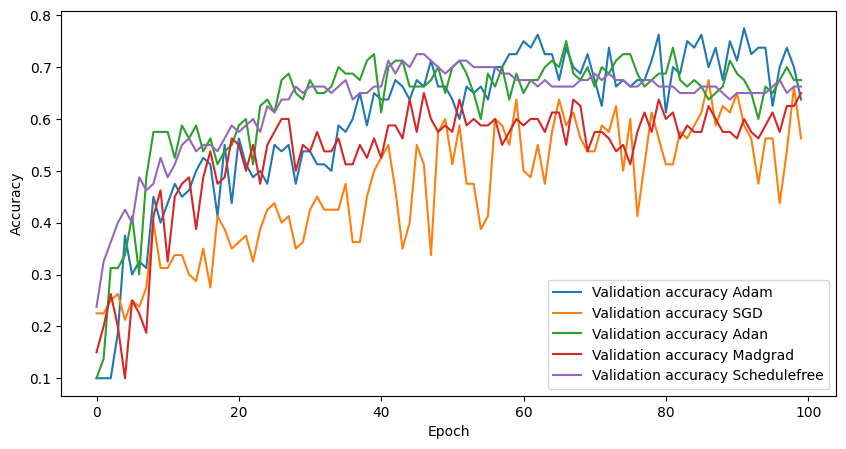

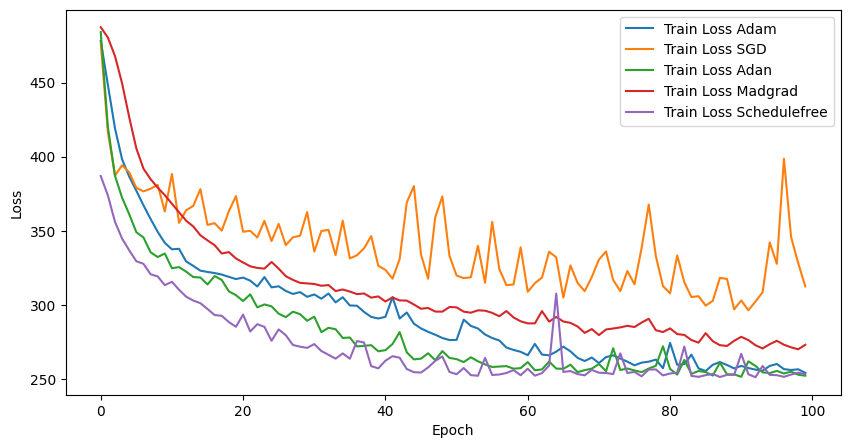

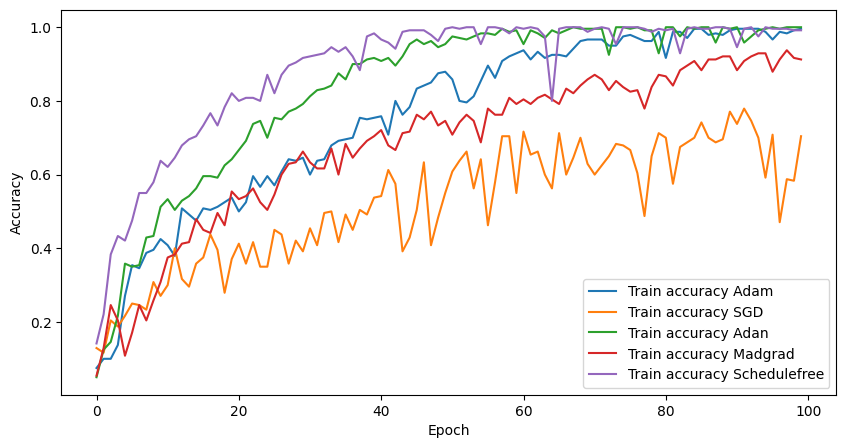

In [31]:
import pickle
with open('trail_two/results_100.pickle', 'rb') as handle:
    final_results = pickle.load(handle)
plot_loss_curve(final_results, val=True, train=False)
plot_accuracy_curve(final_results, val=True, train=False)
plot_loss_curve(final_results, train=True, val=False)
plot_accuracy_curve(final_results, train=True, val=False)

# Madgrad - without clipping

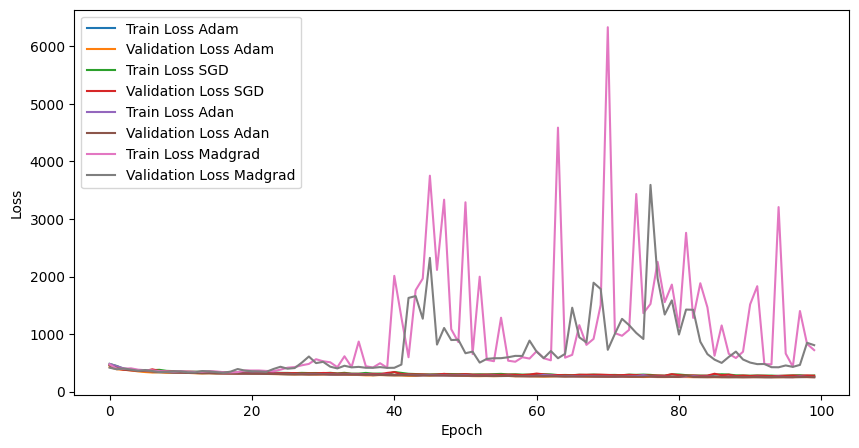

In [35]:



with open('trail_one/madgrad_fail.pickle', 'rb') as handle:
    final_results = pickle.load(handle)
plot_loss_curve(final_results, val=True)

### 500 epochs

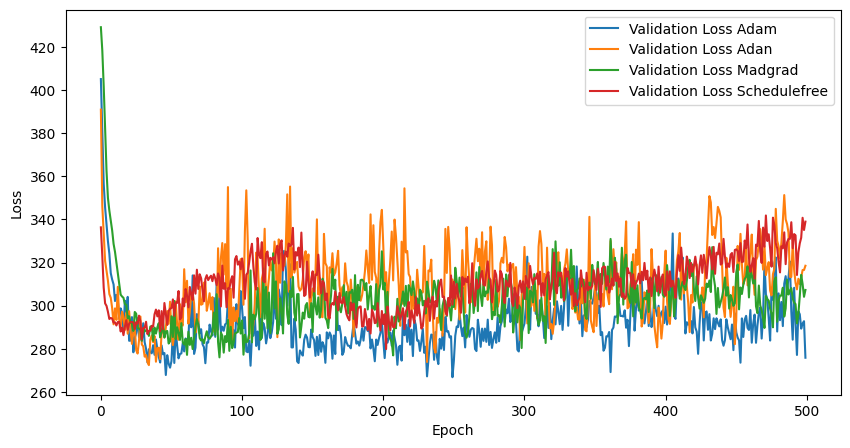

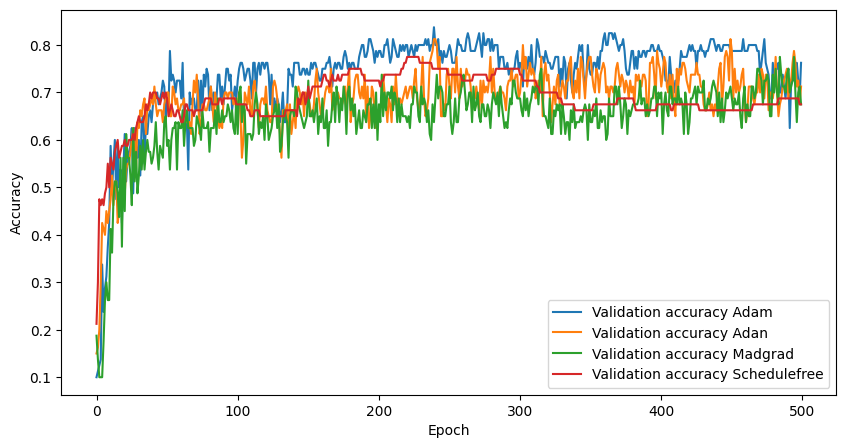

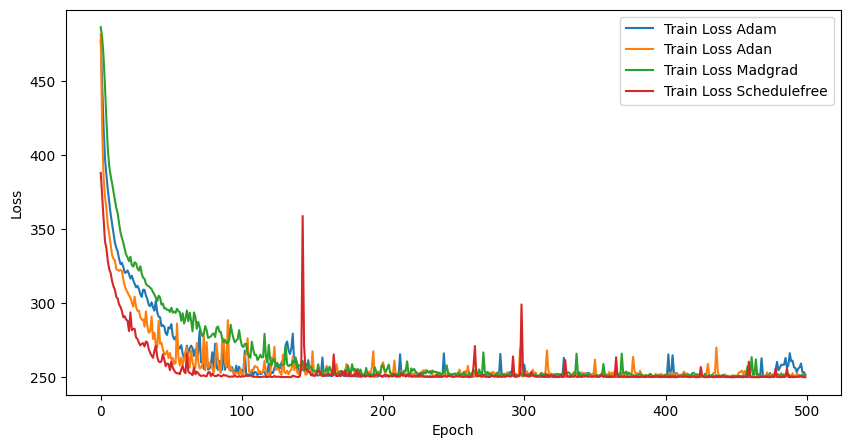

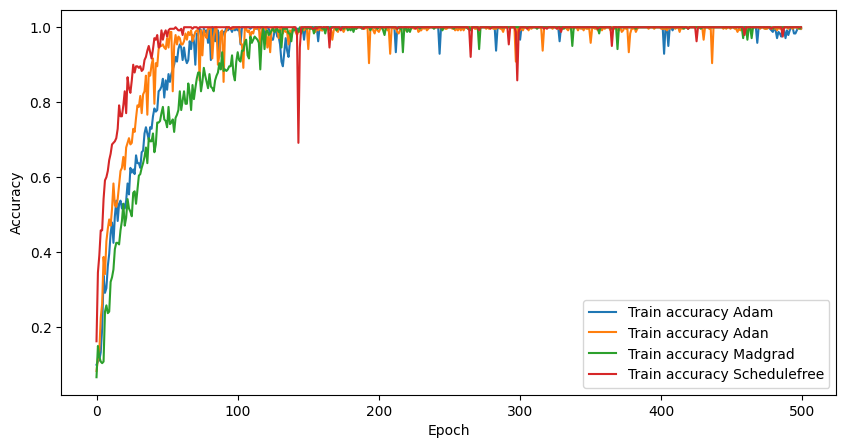

In [30]:
with open('trail_two/results_500.pickle', 'rb') as handle:
    final_results = pickle.load(handle)


plot_loss_curve(final_results, val=True, train=False)
plot_accuracy_curve(final_results, val=True, train=False)
plot_loss_curve(final_results, train=True, val=False)
plot_accuracy_curve(final_results, train=True, val=False)

In [ ]:
# # results_20240812.pickle - 500 iters
# # 'study_20240812/results_20240813 - 100 second try

# # optuna again - study_20240813/results_20240813.pickle
# import pickle
# with open('study_20240812/results_20240813.pickle', 'rb') as handle:
#     final_results = pickle.load(handle)

# with open('study_20240812/results_20240813_free.pickle', 'rb') as handle:
#     schedule_free_res = pickle.load(handle)
# final_results['Schedulefree'] = schedule_free_res['Schedulefree']

# plot_loss_curve(final_results, only_val=False)
# plot_accuracy_curve(final_results, only_val=False)

In [ ]:
# import pickle
# with open('study_20240813/results_20240813.pickle', 'rb') as handle:
#     final_results = pickle.load(handle)
# # final_results['Madgrad'] = results_metric['Madgrad']
# plot_loss_curve(final_results, only_val=False)
# plot_accuracy_curve(final_results, only_val=False)